# Amazon Fine Food Reviews - Building a Co-review graph

In this lab, our general goal is to conduct some exploratory analysis of a medium - large dataset, namely, Amazon Fine Food Reviews, available from a [Kaggle Competition](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews).

Our general goals are the following:

- Retrieve the dataset and upload it onto Colab;
- Build the associated Co-review graph.

## Retrieving the dataset
To retrieve this dataset, we need to be registered Kaggle users. Assuming this is the case, we basically have two options:

1. Download the dataset locally. This can be useful if you want to keep a copy of the data to work with directly on your machine. In this case, you will have to upload the data on Colab in order to work with it. There are several ways to do this, described [here](https://colab.research.google.com/notebooks/io.ipynb). Note that our compressed dataset is about 300MB's and proceeding this way may take some time, depending on your connection.
2. Transferring the data directly from Kaggle to Google. In my experience, this was extremely fast and it is the method I am going to use.

A nice review of all available methods, including the one I am using, can be found [here](https://towardsdatascience.com/7-ways-to-load-external-data-into-google-colab-7ba73e7d5fc7).

### Transferring dataset from Google to Colab
Go to your profile on Kaggle, then ```Account --> Create New API Token``` (you do not have to do every time you run your notebook). The result will be a file called ```kaggle.json```, which you save on your machine. Next, we upload this file to Google Colab as follows:

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


We next specify the above directory as the one to upload the Kaggle dataset to:

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

Next, we need to upload the dataset, issuing the necessary shell command. To do this, we can let Kaggle generate the right command for us. This is done from the Kaggle competion's Web page, in the top-right menu, clicking on the dots and then selecting ```Copy API Command``` as shown in the picture below:

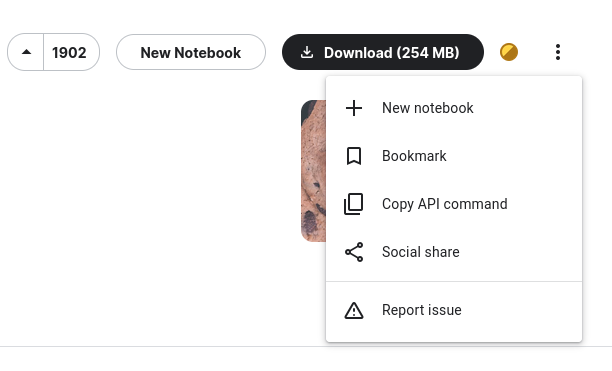

The copy-pasted command is the one shown below:

In [ ]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 96% 233M/242M [00:01<00:00, 186MB/s]
100% 242M/242M [00:01<00:00, 201MB/s]


In [ ]:
!chmod 600 /content/kaggle.json

We next check that everything is there:

In [ ]:
!ls

amazon-fine-food-reviews.zip  kaggle.json  sample_data


We now extract the files from the zipper archive. To this purpose, we use Python zipfile utility package:

In [ ]:
from zipfile import ZipFile

In [ ]:
# Create a ZipFile Object and load sample.zip in it
with ZipFile('amazon-fine-food-reviews.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

Let's check what files are there (we are looking for ```Reviews.csv```)

In [ ]:
!ls

amazon-fine-food-reviews.zip  database.sqlite  hashes.txt  kaggle.json	Reviews.csv  sample_data


There it is. Let us just perform a check that the file looks like it is supposed to be, by having a glance at the first 10 lines:

In [ ]:
!head -10 Reviews.csv

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally co

Keeping roughly $10\%$ of the users for testing purposes. We will see why doing this is reasonable further in the course. For now, try to understand how ```sample_users``` works and why it does the job.

In [ ]:
# Given a Pandas frame raw_pd, save lines corresponding to approximately 10% of the users to file fout
# Note that all lines corresponding to sampled users are saved to fout

import pandas as pd

def sample_users(raw_pd, rate, buckets, fout):
  for index, row in raw_pd.iterrows():
    if (hash(row["UserId"])%buckets < rate):
      # Save this line to fout
      fout.write(row.to_csv(index=False))


sampled_file = "Reviews_sampled.csv"
rate = 10 # 10% of users
buckets = 100

fout = open(sampled_file, "w")
raw_pd = pd.read_csv('Reviews.csv')
sample_users(raw_pd, rate, buckets, fout)
fout.close()

_______________________________________________________

# Assignment 1

First of all we have to install PySpark and import the needed modules

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=fe961a9ef4fa6908974bdefb0a1afdc19bdd60caebcc01504699d4ecc3189493
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import sys
from pyspark import SparkContext, SparkConf

The pipeline I designed is based on many steps:
+ First of all initializing the RDD file I read the .csv as a text file, so I need to filter out the very first row being the header;
+ *First MapReduce block*:
  + Then I have to format each row to collect the data we are interested to, retrieving tuples in the form ```(productID, userID)```: this is done with a ```map``` call on a ```formatting``` subroutine;
  + Now an aggregation step: calling ```groupByKey``` and casting the outputs to lists we collected all the users that reviewd a product, and now we have tuples in the form ```(productID, [userID1, userID2, ...])```
  + Before proceding we filter out all the products having just one review.
+ *Second MapReduce block*:
  + Now with a ```neighboursMapper``` subroutine based on ```itertools.combination``` we extract from each of the list within each tuple all the pairs of distinct users: we make it on all the RDD and flatten in a single list of tuples through a ```flattenMap``` call, emitting tuples in the format ```((user1,user2),1)```;
  + We can now aggregate: every pair of users is a key. We do it through a ```combineByKey``` call that is more efficient than a simple ```reduceByKey``` call, since the former works locally on each mapper and then aggregates globally. The inner function is just an "add primitive", since thorugh summing all the values having the same key we get the number of products that pair of users coreviewed, but for ```combineByKey``` we actually need three inner subroutines:
    + ```createCombiner``` initialize a local aggregator each time a new key is seen;
    + ```mergeValue``` works as a local aggregator within the mapper;
    + ```mergeCombiners``` works as a global aggregator throughout the mappers;
+ *Third MapReduce block*:
  + We now have tuples in the form ```((user1,user2),coreviewedCount)```: through a map call we emit tuple in the form ```(user1,(user2,coreviewedCount))```;
  + Finally we ```groupByKey``` and cast the result as a list, obtaining for each user a tuple like ```(user, [(user1, coreviewedCount1),(user2, coreviewedCount2),...])```.

The whole pipeline can be performed in approximately 5 minutes on Colab. 

In [ ]:
conf = SparkConf().setAppName("CoReviewGraphBuilder").setMaster("local")
sc = SparkContext(conf=conf)

file_in = "Reviews.csv"
f = sc.textFile(file_in)
file_out = "adjList.txt"

In [ ]:
#EMERGENCY STOP - Run to reinitialize the SparkContext if something doesn't work
sc.stop()

### First MapReduce block

In [ ]:
 # Filtering out the header from the RDD file

header = f.first()
f = f.filter(lambda row: row != header)

In [ ]:
# For each row we only need (ProductID, UserID) tuple, so we format the data in this way

def formatting(row):
  splitted = row.split(',')
  return ((splitted[1],splitted[2]))

f = f.map(lambda row: formatting(row))

# Now for each product we are going to build a list with all the users who reviewed it

prod_users = f.groupByKey().mapValues(list)

# We filter out all the tuples having just one review or eventual NA in the keys

prod_users = prod_users.filter(lambda x: isinstance(x[1],list) == True and x[0] != '')

### Second MapReduce block

In [ ]:
# Now for each product we can emit a list of tuples (user1, user2)

import itertools

def neighboursMapper(tup):
  L = []
  for pair in itertools.combinations(tup[1], 2):
      L.append((pair,1))
  return L

pairs = prod_users.flatMap(lambda x: neighboursMapper(x))

# Now we could just reduce by key, being the key the pair (user1, user2)
# But for the seak of efficiency we rather use combineByKey

adjLists = pairs.combineByKey(createCombiner = lambda v: v,
                              mergeValue = lambda v, v_prime: v + v_prime,
                              mergeCombiners = lambda v1, v2: v1 + v2)

### Third MapReduce block

In [ ]:
# This last map-reduce call is to retrieve for each user the adjacency list

adjLists = adjLists.map(lambda x: (x[0][0],(x[0][1],x[1])))
adjLists = adjLists.groupByKey().mapValues(list)

corewGraph = adjLists.collect()

In [ ]:
# Finally we can store and retrieve our output .txt file

out = open(file_out, "w")
for tup in corewGraph:
  out.write(str(tup[0]) + ',' + str(tup[1]) + '\n')

out.close()

from google.colab import files

files.download('adjList.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The following are the first ten lines of the output file as required:

In [1]:
with open('adjList.txt','r') as f:
    lines = f.readlines()

for i in range(10):
    print(lines[i])

A92JIDJABMJKY,[('A2CS4B58345BRL', 1), ('A1MMJ2O6PM8OG7', 1), ('A29BWC41573AF8', 1), ('A1MM0WYBRDZT5O', 1), ('A2JBZWC5IY0AMG', 1), ('ACYR6O588USK', 1), ('A1IQB5BF5VKT0H', 1), ('A2K05W5ZQQH7VI', 1), ('A2ZEFDVX4X5TPX', 1), ('A2GEZJHBV92EVR', 1), ('AW7VIZUKC8ZY3', 1), ('A3TD1O4EC26NT2', 1), ('A280OZI067MIQN', 1), ('A1N5121RR13ZCZ', 1), ('AC0NNJ3Q6YF2N', 1), ('AQ0BWW19DY5KE', 1), ('AJOVLH67GULJD', 1), ('A291HTT117RVS9', 1), ('AM9KC2IIN15JV', 1), ('A3FRWBGL8TSOY7', 1)]

A280OZI067MIQN,[('AQ0BWW19DY5KE', 1), ('A3TAJARZZROSW4', 1), ('A2YQ9TAWNCS7MD', 1), ('ALHKE0V8VBWEZ', 1), ('A1MM0WYBRDZT5O', 1), ('A2ZEFDVX4X5TPX', 1), ('A1G5T652XQM9YA', 1), ('A2D2BRNONA4LYX', 1), ('A1P2SJ67T9M0UX', 1), ('A116HM97LVE571', 1), ('A1HIQK0A0RHM6', 1), ('A32BC4R0D2IATH', 1), ('AXJGCAD36N915', 1), ('A399GGQ2ZSEZGX', 1), ('A2JBZWC5IY0AMG', 1), ('A24DTBQMXSP91Q', 1), ('A2F8YU4ZH94ATP', 1), ('A1JURFCT9KM3M5', 1), ('A2U4M72CSWCF8X', 1), ('AZVVSIYZ2BFW8', 1), ('A3MT2L5RQ97R7M', 1), ('A2YLATQDQMJLOO', 1), ('A2LC4WI692HS